In [1]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20.0.0 (64-bit)
Running under: macOS Sonoma 14.3.1

Matrix products: default
BLAS/LAPACK: /Users/hs0424/miniforge3/envs/r43/lib/libopenblas.0.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] digest_0.6.34   IRdisplay_1.1   utf8_1.2.4      base64enc_0.1-3
 [5] fastmap_1.1.1   glue_1.7.0      htmltools_0.5.7 repr_1.1.6     
 [9] lifecycle_1.0.4 cli_3.6.2       fansi_1.0.6     vctrs_0.6.5    
[13] pbdZMQ_0.3-11   compiler_4.3.2  tools_4.3.2     evaluate_0.23  
[17] pillar_1.9.0    crayon_1.5.2    rlang_1.1.3     jsonlite_1.8.8 
[21] IRkernel_1.3.2  uuid_1.2-0     

In [2]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggrepel)
    library(dplyr)
    library(tidyr)
    library(RColorBrewer)
    library(readr) # for parse_number()
    library(clusterProfiler)
    library(patchwork)
    library(jsonlite)
})
   

In [3]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}   

In [4]:
merged_res_df = read.csv('copulacci_with_other_results.csv')

In [7]:
brca_df = merged_res_df %>%
    mutate(celltype_direction = interaction) %>%
    separate(interaction, into=c("source", "target"), sep = "=") 

In [9]:
brca_df %>% 
    mutate(Correlation = copula_coeff) %>%
    group_by(celltype_direction) %>%
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    ungroup() %>%
    mutate(log10_p.adjust = -log10(qval)) %>%
    mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    mutate(Cluster = celltype_direction) %>%
    #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
    mutate(Correlation = copula_coeff) %>% 
    filter(LR_index == 'WNT9A_FZD8_LRP5')

copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,LR_index,celltype_direction,Correlation,qval,log10_p.adjust,log10_p.adjust_cap,Cluster
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1357658,-11.72496,-10.91479,copula,0.86178862,1.00,0.01055807,0.3692615,0.0141434607,0.2972905,Invasive,Invasive,WNT9A_FZD8_LRP5,Invasive=Invasive,0.1357658,0.9307744,0.031155584,0.031155584,Invasive=Invasive
0.2527027,-11.13130,-10.74765,copula,0.60659898,1.00,-0.16934702,0.2514970,-0.2660087379,1.0000000,Invasive,Tumor,WNT9A_FZD8_LRP5,Invasive=Tumor,0.2527027,0.9842550,0.006892374,0.006892374,Invasive=Tumor
-0.4092793,-11.67673,-10.70778,copula,0.03636364,0.42,-0.06410479,0.1976048,-0.0008790543,1.0000000,Tumor,Surrounding tumor,WNT9A_FZD8_LRP5,Tumor=Surrounding tumor,-0.4092793,0.2464000,0.608359297,0.608359297,Tumor=Surrounding tumor
0.2923423,-11.75525,-10.47283,copula,0.53827160,1.00,0.06826172,0.7325349,-0.0392717105,1.0000000,Healthy,Tumor,WNT9A_FZD8_LRP5,Healthy=Tumor,0.2923423,0.8895454,0.050831904,0.050831904,Healthy=Tumor


In [37]:
dotplot = function(
    brca_df, 
    celltype_name, 
    filter_pos=FALSE, 
    FDR_cutoff = 0.1,
    n_term = 5
){
    brca_df = brca_df %>% filter((source == celltype_name) | 
                    (target == celltype_name))
    if (filter_pos){
        brca_df = brca_df %>% filter(copula_coeff > 0)
    }
    dacr_tbl = brca_df %>% 
        mutate(Correlation = copula_coeff) %>%
        group_by(celltype_direction) %>%
        mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
        ungroup() %>%
        mutate(log10_p.adjust = -log10(qval)) %>%
        mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
        mutate(Cluster = celltype_direction) %>%
        #mutate(Cluster = gsub("="," → ", celltype_direction)) %>%
        #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
        mutate(Correlation = copula_coeff) %>% filter(qval < FDR_cutoff) %>%
        group_by(Cluster) %>% arrange(Correlation) %>% slice_tail(n=n_term) %>% ungroup
        
    # dacr_tbl = brca_df %>%
    #     mutate(Correlation = copula_coeff) %>%
    #     mutate(qval = p.adjust(pval, method = "BH")) %>%
    #     mutate(log10_p.adjust = -log10(qval)) %>%
    #     mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    #     mutate(Cluster = celltype_direction) %>%
    #     #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
    #     mutate(Correlation = copula_coeff) %>% 
    #     group_by(Cluster) %>% arrange(Correlation) %>% slice_tail(n=n_term) %>% ungroup
    mat <- dacr_tbl %>% 
      select(Correlation, celltype_direction, LR_index) %>%  
      tidyr::pivot_wider(names_from = celltype_direction, values_from = Correlation) %>% 
      data.frame() # make df as tibbles -> matrix annoying
    
    df_toplot = dacr_tbl 
    df_toplot$lig_rec = factor(df_toplot$LR_index, levels=mat$LR_index)
    theme_cancer = theme_bw() + theme(
        legend.position = "bottom", 
        axis.text = element_text(color="black"), 
        axis.text.x = element_text(size=14, angle = 90, vjust = 0.5, hjust=1),
        plot.margin = margin(0,0,0,0,'pt')
    )

    p_dot = ggplot(df_toplot, 
                   aes_string(
                       x="Cluster", y="lig_rec", 
                       fill="log10_p.adjust_cap", size="Correlation")) +
      geom_point(shape=21, color="black") +
      paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
                                        limits = c(-log10(FDR_cutoff), 3.1), 
                                        breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
                                        labels = c(FDR_cutoff, "0.2", "0.05", "0.01", "0.001")) +
      scale_size(range=c(1,7)) +
      theme_cancer +
      theme(axis.text = element_text(size=12, color="black")) + 
      labs(y="", x="",title="", size="Correlation", fill="FDR") +
      theme(axis.text.y = element_text(size=14)) +
      theme(legend.position="right", legend.box="vertical") +
      ggtitle(celltype_name) +
      theme(plot.title = element_text(hjust = 0.5))

    return(p_dot)
}

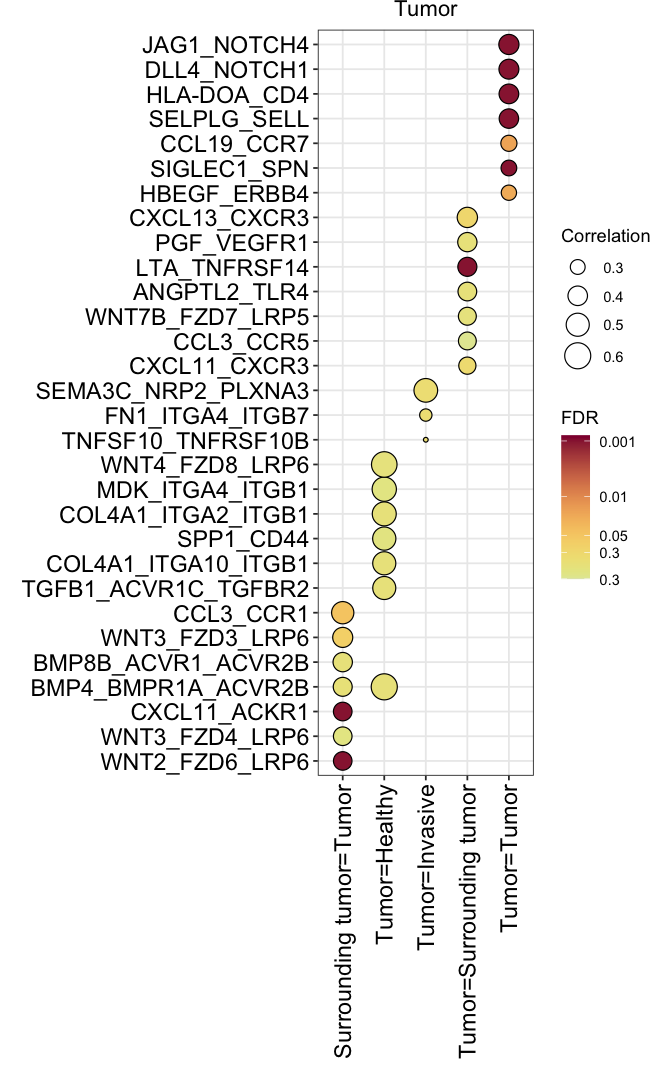

In [65]:
fig.size(9,5.5)
dotplot(brca_df, "Tumor",filter_pos=TRUE,FDR_cutoff=0.3,n_term=7)

In [57]:
df =  brca_df %>% 
        mutate(Correlation = copula_coeff) %>%
        group_by(celltype_direction) %>%
        filter(Correlation > 0) %>%
        mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    filter(celltype_direction == 'Tumor=Surrounding tumor')

In [58]:
df %>% filter(qval < 0.1) %>%
    group_by(celltype_direction) %>% arrange(Correlation) %>% 
    slice_tail(n=5) %>% ungroup

copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,LR_index,celltype_direction,Correlation,qval
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0.2011712,-11.64548,-8.051856,copula,0.000000000,0.0000000,0.06975543,0.195608782,-0.03487421,1.000000e+00,Tumor,Surrounding tumor,PTN_SDC4,Tumor=Surrounding tumor,0.2011712,0.00000000
0.2071171,-10.61586,-8.940115,copula,0.000000000,0.0000000,0.08298050,0.087824351,0.01260277,1.220831e-09,Tumor,Surrounding tumor,TGFB3_ACVR1_TGFBR1,Tumor=Surrounding tumor,0.2071171,0.00000000
0.3101802,-11.74233,-10.331299,copula,0.000000000,0.0000000,0.16041399,0.001996008,0.08691256,0.000000e+00,Tumor,Surrounding tumor,IL16_CD4,Tumor=Surrounding tumor,0.3101802,0.00000000
0.3874775,-13.33496,-9.609165,copula,0.000000000,0.0000000,0.11504356,0.009980040,0.03263461,2.876230e-56,Tumor,Surrounding tumor,LTA_TNFRSF14,Tumor=Surrounding tumor,0.3874775,0.00000000
0.4191892,-11.90784,-11.449714,copula,0.005747126,0.2028202,0.04536632,0.427145709,0.03628294,3.766664e-69,Tumor,Surrounding tumor,CXCL13_CXCR3,Tumor=Surrounding tumor,0.4191892,0.09853021


In [59]:
df %>% filter(qval < 0.2) %>%
    group_by(celltype_direction) %>% arrange(Correlation) %>% 
    slice_tail(n=5) %>% ungroup

copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,LR_index,celltype_direction,Correlation,qval
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0.3617117,-12.18228,-10.385004,copula,0.030612245,0.4017857,0.030101349,0.50698603,-0.04238064,1.000000e+00,Tumor,Surrounding tumor,WNT7B_FZD7_LRP5,Tumor=Surrounding tumor,0.3617117,0.19441461
0.3795495,-11.48913,-10.873101,copula,0.021052632,0.3577919,-0.012703274,0.79840319,-0.02205551,1.000000e+00,Tumor,Surrounding tumor,ANGPTL2_TLR4,Tumor=Surrounding tumor,0.3795495,0.17001292
0.3874775,-13.33496,-9.609165,copula,0.000000000,0.0000000,0.115043562,0.00998004,0.03263461,2.876230e-56,Tumor,Surrounding tumor,LTA_TNFRSF14,Tumor=Surrounding tumor,0.3874775,0.00000000
0.3934234,-11.70899,-10.850878,copula,0.025229358,0.3584935,-0.002369331,0.97005988,-0.03110898,1.000000e+00,Tumor,Surrounding tumor,PGF_VEGFR1,Tumor=Surrounding tumor,0.3934234,0.17078570
0.4191892,-11.90784,-11.449714,copula,0.005747126,0.2028202,0.045366323,0.42714571,0.03628294,3.766664e-69,Tumor,Surrounding tumor,CXCL13_CXCR3,Tumor=Surrounding tumor,0.4191892,0.09853021


In [40]:
fdr_cutoffs <- seq(0, 0.5, by = 0.01)
lr_counts <- sapply(fdr_cutoffs, function(cutoff) sum(df$qval <= cutoff))
fdr_df <- data.frame(fdr_cutoff = fdr_cutoffs, lr_counts = lr_counts)

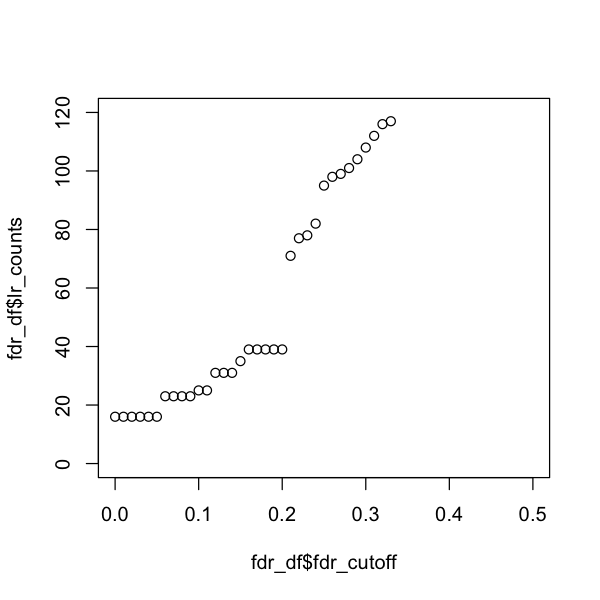

In [49]:
fig.size(5,5)
plot(fdr_df$fdr_cutoff, fdr_df$lr_counts,ylim=c(0,120))

In [68]:
plot_scatter = function(brca_df, xcol, ycol, gpair, FDR_cutoff=0.1, ntop=5, use_cutoff=FALSE){
    
    df_ct = brca_df %>% 
    mutate(Correlation = copula_coeff) %>%
    group_by(celltype_direction) %>%
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    ungroup() %>%
    mutate(log10_p.adjust = -log10(qval)) %>%
    mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    mutate(Cluster = celltype_direction) %>%
    filter(celltype_direction == gpair)

    df_ct = df_ct %>% select(c(LR_index, copula_coeff, log10_p.adjust_cap, scc, global_I, qval)) 
    xmax = max(df_ct[[xcol]]) 
    xmin = min(df_ct[[xcol]])
    ymax = max(df_ct[[ycol]]) 
    ymin = min(df_ct[[ycol]])
    gmin = min(xmin, ymin)
    gmax = max(xmax, ymax)
    df_ct$method_diff = abs(df_ct[[xcol]] - df_ct[[ycol]])
    if(use_cutoff){
        top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% arrange(method_diff) %>% slice_tail(n=ntop) %>% pull(LR_index)
    }else{
        top_candidates = df_ct %>% arrange(method_diff) %>% slice_tail(n=ntop) %>% pull(LR_index)
    }
    #p_value = "log10_p.adjust_cap"
    p_value = "qval"
    p_scatter = ggplot(df_ct, aes_string(x = xcol, y = ycol, color = p_value)) +
      scale_color_gradient(
        # limits = c(-log10(max(df_ct$qval)), 3.1), 
        # breaks = -log10(c(0.9, 0.1, 0.05, 0.01, 0.001)), 
        # labels = c("0.9", "0.1", "0.05", "0.01", "0.001"),
        low = "blue", high = "grey") +
      geom_point(alpha = 0.6, size=3) + 
      geom_point(data = df_ct %>% filter(LR_index %in% top_candidates), 
                 color = "red", size = 3.5, stroke=1.3, shape = 1) +  # Red border for specific points
      geom_text_repel(
        aes(label = ifelse(LR_index %in% top_candidates, LR_index, "")),
        box.padding = 0.35,
        point.padding = 0.5,
        segment.color = 'grey50',
        color = "red",  # Set label text color
        size = 5,       # Set label text size
        alpha = 1,      # Set label text transparency
        max.overlaps = Inf
      ) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal dashed line
      geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical dashed line
      theme_bw() +
      theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line = element_line(colour = "black"),
        # axis.title.x = element_blank(),
        # axis.title.y = element_blank(),
        axis.text.x = element_text(family = "Helvetica", size = 18, color = "black"),
        axis.text.y = element_text(family = "Helvetica", size = 18, color = "black")
      ) +
        xlim(gmin,gmax) +
        ylim(gmin,gmax) +
      labs(color = "FDR")
    
    return(p_scatter)
}

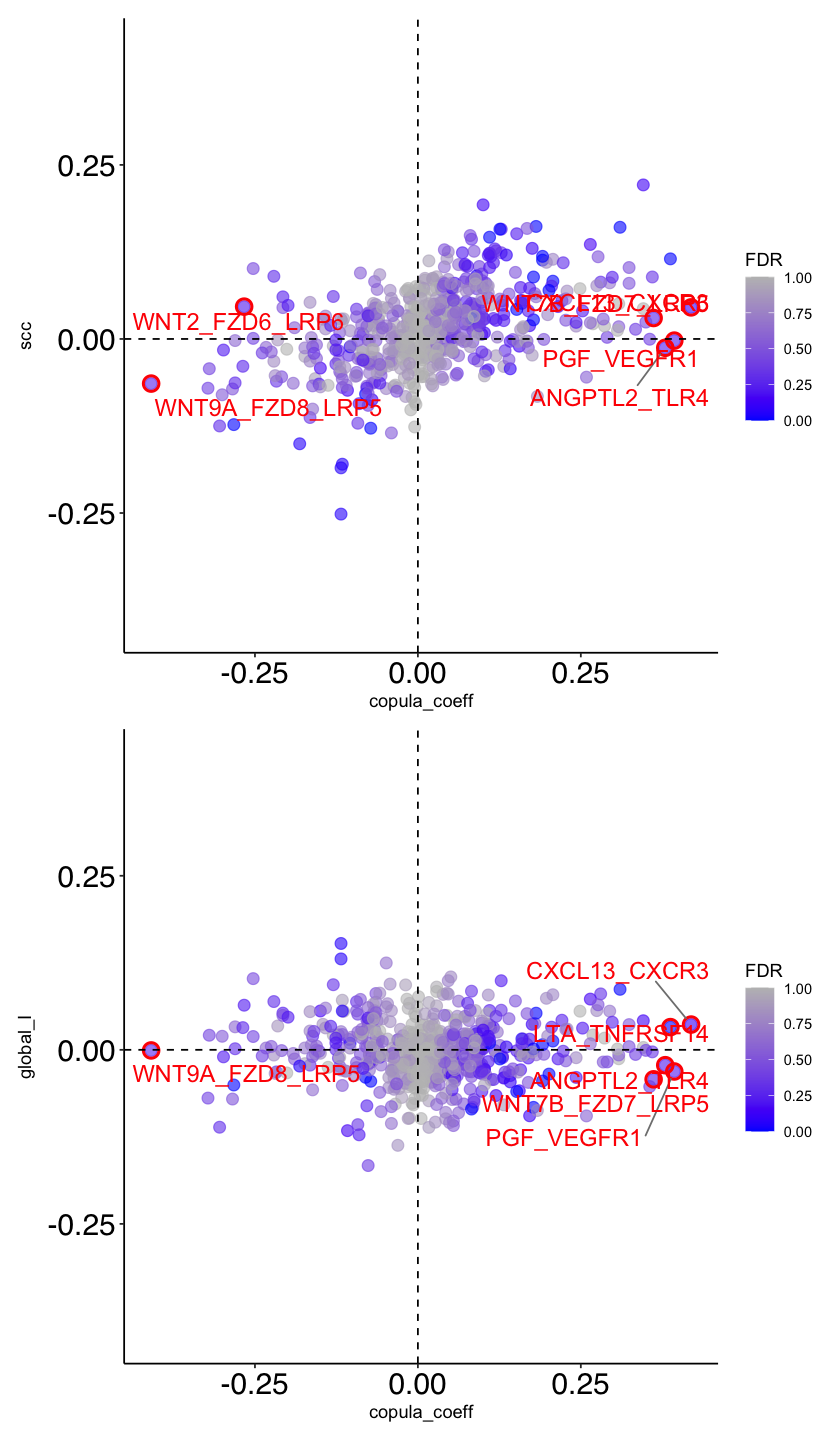

In [72]:
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=6,FDR_cutoff=0.3, use_cutoff=TRUE)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=6,FDR_cutoff=0.3, use_cutoff=TRUE)
fig.size(12,7)
p3 = p1 / p2
p3